In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


### Data generation of frecuency modes

In [2]:
generate_data_modes <- function(deltaNu, nuRange, deltaR, numPoints) {
  # DS to return data
  df <- data.frame()
  # Range for data generation
  range <- c(nuRange[1] * deltaNu, nuRange[2] * deltaNu)
  
  # L0 distance from origin
  range_dl0 <- c(0, 10)
  
  # Avoid negative ranges
  dl0 <- round(runif(1, range_dl0[1], range_dl0[2]), 2)
  while (range[2] - (range[1] + dl0)<0) {
    dl0 <- round(runif(1, range_dl0[1], range_dl0[2]), 2)
  }
  # Vector generation
  l0 <- seq(
    from = range[1] + dl0,
    to = range[2],
    by = (range[2] - (range[1] + dl0)) / numPoints
  )[1:numPoints]
  # Append data
  df <-
    rbind(df, data.frame(
      "frequency" = l0,
      "mode" = "l0",
      "amplitude" = 1
    ))
  
  
  # L1 distance from origin
  dl1 <-
    round(runif(1, 0, l0[2] - l0[1]), 2) # Rand betwee first and second L2
  # Vector generation
  l1 <- seq(
    from = l0[1] + dl1,
    to = range[2],
    by = (range[2] - (l0[1] + dl1)) / numPoints
  )[1:numPoints]
  
  # Append data
  df <-
    rbind(df,
          data.frame(
            "frequency" = l1,
            "mode" = "l1",
            "amplitude" = 0.8
          ))
  
  
  # M-1, M1 distance from l1
  dr <- round(runif(1, 0, deltaNu), 2)
  
  mp1 <- l1 + dr
  ml1 <- l1 - dr
  
  # Append data
  df <-
    rbind(df,
          data.frame(
            "frequency" = mp1,
            "mode" = "mp1",
            "amplitude" = 0.75
          ))
  df <-
    rbind(df,
          data.frame(
            "frequency" = ml1,
            "mode" = "ml1",
            "amplitude" = 0.75
          ))
  
  stopifnot(length(l0) == numPoints) # Length assert for L0
  stopifnot(length(l1) == numPoints) # Length assert for L0
  stopifnot(length(mp1) == numPoints) # Length assert for L0
  stopifnot(length(ml1) == numPoints) # Length assert for L0
  
  return(list(
    "data" = df,
    "dl0" = dl0,
    "dl1" = dl1,
    "dr" = dr,
    "dnu" = deltaNu
  ))
}

### Random experiment generation

In [278]:
trunc <-
  function(x, ..., prec = 1)
    base::trunc(x * 10 ^ prec, ...) / 10 ^ prec

experiment_number <- 5000

# Input dimension
cuts_breaks <- c(-Inf,seq(0,101,0.5),Inf)
input_dim <- length(cuts_breaks) - 1
# Output dimension
num_classes <-
  length(seq(from = 0.1, to = 10/0.0864, by = 1)) # Buckets of possible classes
  
if (F) {
  # Save to disk
  load(file = "~/Downloads/x_train.RData")
  load(file = "~/Downloads/x_test.RData")
  load(file = "~/Downloads/y_train.RData")
  load(file = "~/Downloads/y_test.RData")
} else {
  # Matrix to save genereated data
  #m_xtrain <- matrix(nrow = experiment_number + 1, ncol = input_dim, dim=c(1,3))
  #m_ytrain <- matrix(nrow = experiment_number + 1, ncol = num_classes)
  
  # 2D dimensional array for X train
  rows <- experiment_number + 1
  cols <- input_dim
  dimensions <- 3 # Number of channels
  m_xtrain <- array(0, c(rows, cols, dimensions))
  # Y train is a 1D matrix with rows and targets
  m_ytrain <- matrix(nrow = rows, ncol = num_classes)
  
  
  # Loop generating data
  count <- 1
  for (experiment in seq(1:(experiment_number+1))) {
    # Select experiment parameters
    dnu <- trunc(runif(1, 1, 10), prec = 4)
    dr <- trunc(runif(1, 0, dnu), prec = 4)
    # Debug info with experiment configuration
    if (count %% 250 == 0) {
      print(
        paste(
          "Experiment:",
          count,
          " | dnu:",
          dnu,
          " | dr:",
          dr,
          sep = ""
        )
      )
    }
    
    # Data generation
    dt <- generate_data_modes(
      deltaNu = dnu,
      deltaR = dr,
      nuRange = c(2.5, 10),
      numPoints=7
    )
    # Execute experiment
    result <- process(
      frequency = dt$data$frequency,
      amplitude = dt$data$amplitude,
      filter = "uniform",
      gRegimen = 0,
      maxDnu = 15,
      minDnu = 15,
      numFrequencies = ifelse(nrow(dt$data) < 30, 31, nrow(dt) + 1),
      dnuGuessError = -1,
      debug = F
    )
    
    # X data
    # ----------------------
    # Save fourier transform
    ftS <- stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv), 
                     as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b), 
                     breaks=cuts_breaks)$stats
    ft_1D <- ftS[2,1:(length(cuts_breaks)-1)]
    ft_1D[is.na(ft_1D)] <- 0

    
    
    # Save histogram of diffs
    diffS <- stats.bin(as.numeric(result$diffHistogram$histogram$bins), 
                       as.numeric(result$diffHistogram$histogram$values), 
                       breaks=cuts_breaks)$stats
    diff_2D <- diffS[2,1:(length(cuts_breaks)-1)]
    diff_2D[is.na(diff_2D)] <- 0
    
    # Save crosscorrelation
    cross <- stats.bin(as.numeric(result$crossCorrelation$index), 
                       as.numeric(result$crossCorrelation$autocorre), 
                       breaks=cuts_breaks)$stats
    cross_3D <- cross[2,1:(length(cuts_breaks)-1)]
    cross_3D[is.na(cross_3D)] <- 0
    
    # Assert all dimensions are equal
    stopifnot((length(ft_1D) == length(diff_2D)) == 
                ((length(diff_2D) == length(cross_3D)) == 
                   (length(cross_3D) == length(cuts_breaks)-1)))
      
    # X data
    normalized <- function(x){ (x-min(x))/(max(x)-min(x)) }
    m_xtrain[count, , 1] <- normalized(ft_1D)
    m_xtrain[count, , 2] <- normalized(diff_2D)
    m_xtrain[count, , 3] <- normalized(cross_3D)
      
    
  # Y data
    m_ytrain[count, ] <-
      to_categorical(round(dt$dnu / 0.0864, 3), num_classes) +
      to_categorical(round(dt$dr / 0.0864, 3), num_classes)
      
    count <- count + 1
  }
    
    # Split train/test
    smp_size <- floor(0.75 * nrow(m_xtrain))
    set.seed(123)
    ind <- sample(seq_len(nrow(m_xtrain)), size = smp_size)

    # Prepare partition
    x_train <- m_xtrain[ind,,]
    x_test  <- m_xtrain[-ind,,]
    y_train <- m_ytrain[ind,]
    y_test  <- m_ytrain[-ind,]

    # Save to disk
    save(x_train, file = "~/Downloads/x_train.RData")
    save(x_test, file = "~/Downloads/x_test.RData")
    save(y_train, file = "~/Downloads/y_train.RData")
    save(y_test, file = "~/Downloads/y_test.RData")
}

[1] "Experiment:250 | dnu:3.7055 | dr:2.7868"
[1] "Experiment:500 | dnu:9.3005 | dr:5.5876"
[1] "Experiment:750 | dnu:7.3769 | dr:4.5349"
[1] "Experiment:1000 | dnu:1.178 | dr:0.3951"
[1] "Experiment:1250 | dnu:2.6661 | dr:2.5781"
[1] "Experiment:1500 | dnu:2.3925 | dr:0.1064"
[1] "Experiment:1750 | dnu:9.521 | dr:9.1331"
[1] "Experiment:2000 | dnu:4.5138 | dr:0.2987"
[1] "Experiment:2250 | dnu:3.1798 | dr:1.5264"
[1] "Experiment:2500 | dnu:2.7981 | dr:0.3727"
[1] "Experiment:2750 | dnu:5.8822 | dr:4.4548"
[1] "Experiment:3000 | dnu:6.1543 | dr:1.1837"


In [293]:
dim(m_xtrain[ind,,])
dim(m_ytrain[ind,])

[1] 2250  204    3

[1] 2250  116

#### Data asserts and reshaping

In [294]:
# Asserts on data training and test
stopifnot(dim(m_xtrain)[1] == dim(m_ytrain)[1])
stopifnot(length(which(!complete.cases(m_ytrain))) == 0)

#x_train <- array_reshape(x_train, c(dim(x_train), 1))
#x_test  <- array_reshape(x_test, c(dim(x_test), 1))

dim(x_train)
dim(y_train)

dim(x_test)
dim(y_test)

[1] 2250  204    3

[1] 2250  116

[1] 751 204   3

[1] 751 116

In [295]:
apply(y_train,2,sum)
apply(y_test,2,sum)

[1] 45 52 46 46 35 47 63 53 50 58 48 50 71 81 77 56 61 81 69 42 57 62 55 60 60
 [26] 61 60 50 58 40 47 61 55 47 53 53 36 46 37 53 46 38 43 41 39 51 42 33 38 35
 [51] 41 43 44 38 36 44 35 52 43 42 32 26 32 30 29 28 35 32 27 36 42 33 30 26 24
 [76] 30 27 33 33 29 28 30 28 25 27 31 20 29 30 24 19 31 27 23 25 20 32 30 33 31
[101] 26 25 19 25 16 22 20 25 21 18 23 22 17 21 26 11

[1] 17 17 17 19 22 14 17 17  9 14 10 16 21 23 17 24 18 20 16 23 18 20 16 20 16
 [26] 26 21 21 20 18 12 19 14  8 12 11 10 11 19 15 20 12 14 23 16 12 14 12 13 15
 [51] 11 14  8 17 12 11 12 10 15 13 15 14 15  7 12 19  9 11 13 12 17 13  9 11 13
 [76]  9 17  9 11  8 10  4  8  8  7  9  7  8 15  8 11 11 10  7  7 13 11  9  8  8
[101]  3  7  8 12 15  6  5  9 15  9 11  9  6  7  2  3

### NN Architecture

In [299]:
# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  
  # Encoder
  layer_conv_1d(
    filters = 20,
    kernel_size = 10,
    activation = 'relu',
    input_shape = c(204,3)
  ) %>%
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_dropout(0.4) %>%
  layer_batch_normalization() %>%

    layer_conv_1d(
    filters = 20,
    kernel_size = 10,
    activation = 'relu',
    input_shape = c(204,3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.4) %>%
  layer_batch_normalization() %>%


  layer_flatten() %>%
  layer_dense(num_classes, activation = 'softmax')

# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c("accuracy")
)
summary(model) # Plot summary

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d_43 (Conv1D)                  (None, 195, 20)                 620         
________________________________________________________________________________
max_pooling1d_39 (MaxPooling1D)     (None, 65, 20)                  0           
________________________________________________________________________________
dropout_48 (Dropout)                (None, 65, 20)                  0           
________________________________________________________________________________
batch_normalization_37 (BatchNormal (None, 65, 20)                  80          
________________________________________________________________________________
conv1d_44 (Conv1D)                  (None, 56, 20)                  4020        
________________________________________________________________________________
max_pooling1d_40 (MaxPooling

#### Model training

In [300]:
# Fit model
history <- model %>% fit(
  x_train,
  y_train,
  epochs = 20000,
  batch_size =  250,
  validation_split = 0.3,
  shuffle = T
)

In [ ]:
plot(history) +
  theme_bw()

#### Model evalution on validation data

In [301]:
evaluate(model, x_test, y_test)

$loss
[1] 7.366285

$acc
[1] 0.2676431

In [297]:
#### Confusion matrix

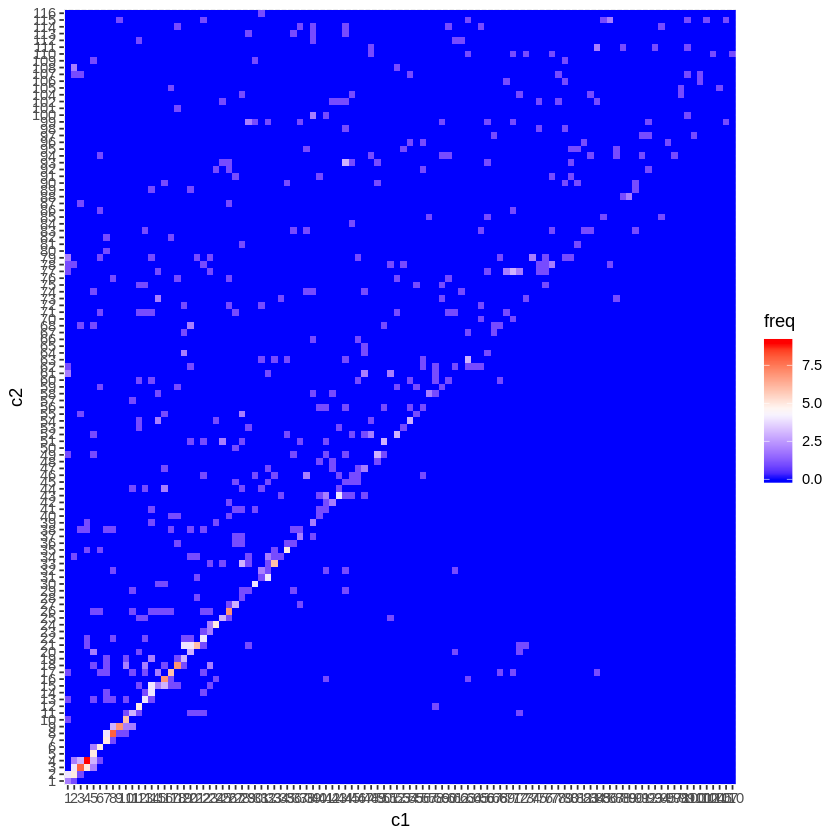

In [302]:
Y_test_hat <- predict_classes(model, x_test) + 1
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Show first subset
#range <-1:30
#cm[range, range]

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

In [62]:
precission <- 4
recall <- 20

y_hats <- predict(model, x_test)
n <- dim(x_test)[1]
matchs <- c()
for (i in seq(1:n)) {
  # First diffs (firsts given by the recall) for first frecuency
  diffsF <-
    abs(which(y_test[i,] == 1)[1] - sort(y_hats[i,], index.return = TRUE, decreasing =
                                           T)$ix[1:recall])
  # First diffs (firsts given by the recall) for second frecuency
  diffsS <-
    abs(which(y_test[i,] == 1)[2] - sort(y_hats[i,], index.return = TRUE, decreasing =
                                           T)$ix[1:recall])
  
  # Check precission and match both patterns
  flag <-
    (ifelse(length(diffsF[diffsF <= precission]) > 1, 1, 0) +
       ifelse(length(diffsS[diffsS <= precission]) > 1, 1, 0)) == 2
  
  # Concatenate
  matchs <- c(matchs, flag)
}
#table(matchs)
f <- as.numeric(table(matchs)["FALSE"])
t <- as.numeric(table(matchs)["TRUE"])

print(paste("Accuracy MAP@: ", recall, ": ", round(t / dim(x_test)[1], 4), sep =
              ""))

[1] "Accuracy MAP@: 20: 0.8208"


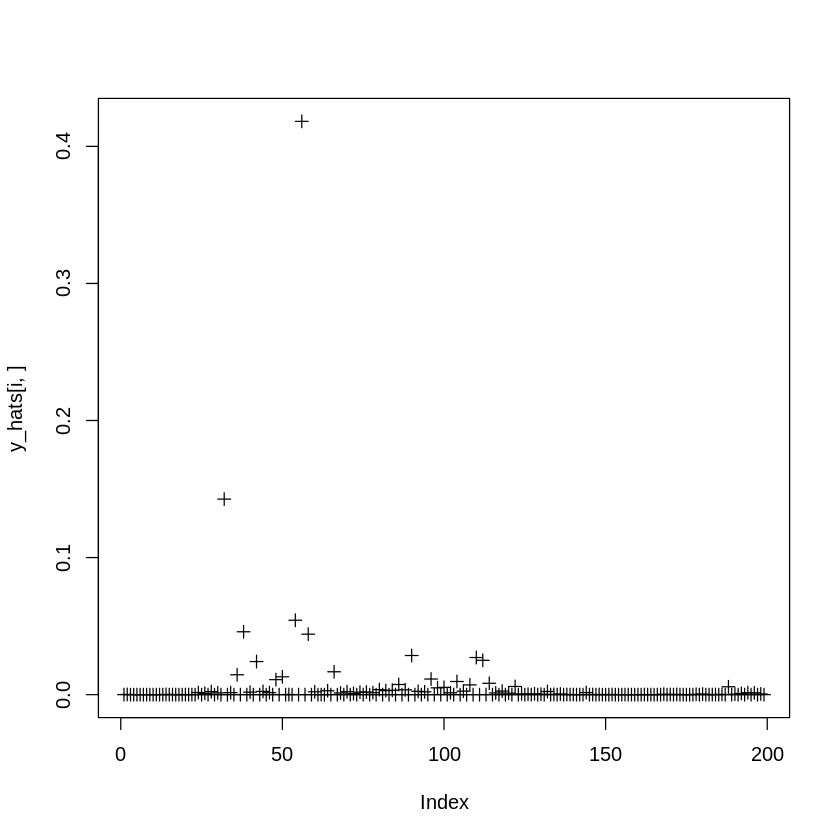

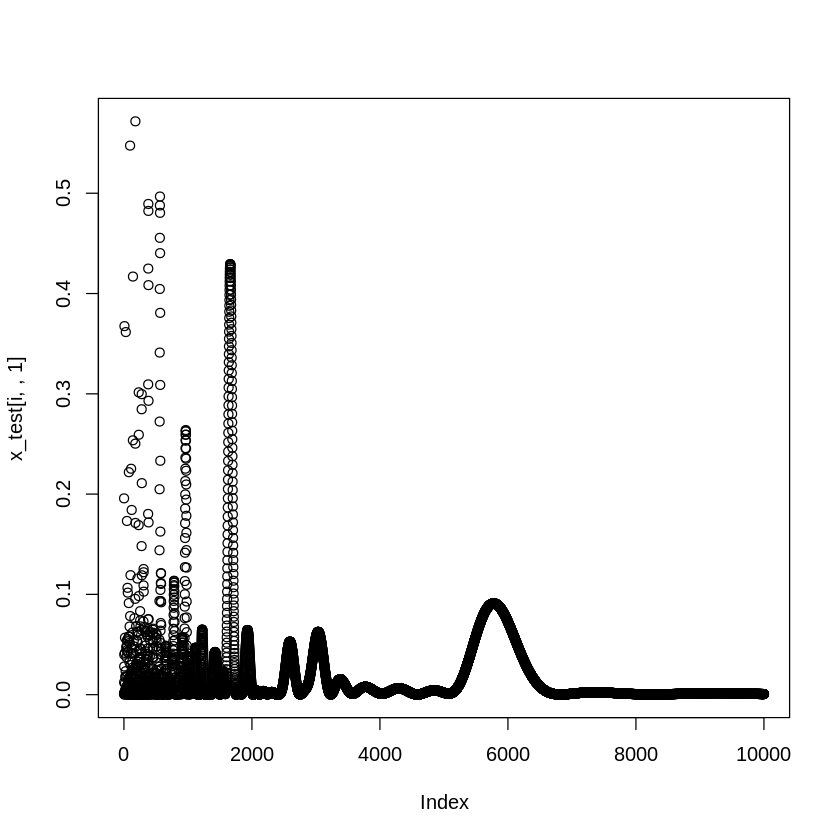

In [54]:
i <- 10
plot(y_hats[i,],pch = 3)
plot(x_test[i,,1])